In [1]:
from collections import defaultdict
from datetime import datetime
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import norm, exponnorm

%matplotlib notebook

In [2]:
team_years_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/v2/team_years.csv")
events_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/v2/events.csv")
team_events_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/v2/team_events.csv")
matches_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/v2/matches.csv")
team_matches_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/v2/team_matches.csv")

C:\Users\Abhijit\AppData\Local\Temp\ipykernel_19664\3646098717.py:4: DtypeWarning: Columns (12,13,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  matches_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/v2/matches.csv")


In [3]:
matches_df = pd.merge(matches_df, events_df[["key", "week"]], left_on="event", right_on="key").rename(columns={"key_x": "key"}).drop(columns=["key_y"])

## Distribution of EPA End - EPA Start

In [4]:
subset_team_events_df = team_events_df[(team_events_df.year == 2019) & (team_events_df.offseason == False)]
epa_start = subset_team_events_df.epa_start
epa_end = subset_team_events_df.epa_end

(1.603493783085067, 3.9822523864624846)


<IPython.core.display.Javascript object>


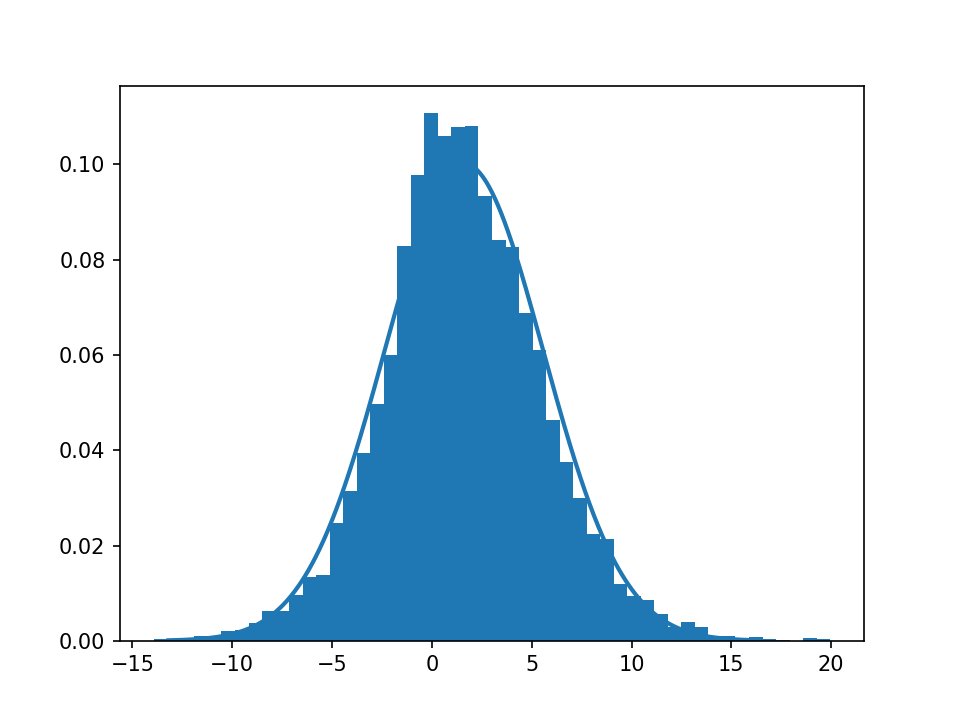

In [5]:
data = (epa_end - epa_start)
distrib = norm

config = distrib.fit(data)
print(config)
x = np.linspace(distrib.ppf(0.0001, *config), distrib.ppf(0.9999, *config), 1000)

fig, ax = plt.subplots()
ax.hist(data, bins=50, density=True)
ax.plot(x, distrib.pdf(x, *config), lw=2, color="tab:blue", label="2022 Trend")
fig.show()

# Find that epa_end - epa_start ~ N(c, 25% of Week 1 SD)

## Predicting Events with EPA End

In [6]:
subset_team_events_df = team_events_df[(team_events_df.year == 2022) & (team_events_df.offseason == False)]
starting_epas = {(x.event, x.team): x.epa_start for _, x in subset_team_events_df.iterrows()}
ending_epas = {(x.event, x.team): x.epa_end for _, x in subset_team_events_df.iterrows()}

In [7]:
class ModelStats:
    def __init__(self):
        self.win_prob = []
        
    def record_stats(self, match, red_pred, blue_pred, win_prob):
        winner = {"blue": 0, "red": 1, "draw": 0.5}[match.winner]
        common = {"week": match.week, "event": match.event, "playoff": match.playoff, "key": match.key}
        
        self.win_prob.append({
            **common, 
            "winner": match.winner, 
            "win_prob": win_prob, 
            "conf": max(win_prob, 1 - win_prob), 
            "acc": (win_prob > 0.5) == winner, 
            "mse": (winner - win_prob) ** 2,
        })
            
    def print_stats(self):
        win_prob_df = pd.DataFrame(self.win_prob)
        
        def agg_win_prob(name, _filter):
            temp_df = _filter(win_prob_df)
            temp = temp_df.agg({"event": "count", "conf": "mean", "acc": "mean", "mse": "mean"})
            rounded = [f"{temp.conf:.4f}", f"{temp.acc:.4f}", f"{temp.mse:.4f}"]
            print("\t".join([name + "\t", str(int(temp.event))] + rounded))
            
        print("Win Prob")
        print("Category\tCount\tConf\tAcc\tMSE")
        agg_win_prob("Season", lambda x: x[(x.week < 8)])
        agg_win_prob("Champs", lambda x: x[(x.week == 8)])
        agg_win_prob("Quals", lambda x: x[(x.playoff == False)])
        agg_win_prob("Elims", lambda x: x[(x.playoff == True)])
        agg_win_prob("Total", lambda x: x)
        print()

In [8]:
def process_season(year, MEAN, SD, prior_epas):
    team_years = {}
    model_stats = ModelStats()
    for _, match in matches_df[(matches_df.year == year) & (matches_df.offseason == False)].iterrows():
        red_teams = [int(match.red_1), int(match.red_2), int(match.red_3)]
        blue_teams = [int(match.blue_1), int(match.blue_2), int(match.blue_3)]
        red_pred = sum([prior_epas.get((match.event, t), MEAN / 3) for t in red_teams])
        blue_pred = sum([prior_epas.get((match.event, t), MEAN / 3) for t in blue_teams])
        win_prob = 1 / (1 + 10 ** (-1 * (red_pred - blue_pred) / SD))
        model_stats.record_stats(match, red_pred, blue_pred, win_prob)
    
    model_stats.print_stats()

process_season(2022, 41, 22, starting_epas)
process_season(2022, 41, 22, ending_epas)

# An event is much better approximated by its end of event EPAs than pre event EPAs
# Can think of a team_event as having a consistent EPA, matches used to find it (end EPA)
# Equipped with distribution of end EPAs, can run simulations

Win Prob
Category	Count	Conf	Acc	MSE
Season		13806	0.7580	0.7266	0.1689
Champs		869	0.8502	0.7629	0.1611
Quals		12074	0.7601	0.7266	0.1685
Elims		2601	0.7792	0.7386	0.1682
Total		14675	0.7635	0.7287	0.1685

Win Prob
Category	Count	Conf	Acc	MSE
Season		13806	0.8113	0.8370	0.1069
Champs		869	0.8402	0.8285	0.1132
Quals		12074	0.8125	0.8399	0.1042
Elims		2601	0.8152	0.8205	0.1214
Total		14675	0.8130	0.8365	0.1072



## Current Simulation

In [9]:
year = 2019
year_sd = 17.1

event_team_events_dict = {k: v for k, v in team_events_df.groupby("event")}
event_matches_dict = {k : v for k, v in matches_df[matches_df.playoff == False].sort_values(by=["time"]).groupby("event")}
event_team_matches_dict = {k: v for k, v in team_matches_df[team_matches_df.playoff == False].sort_values(by=["time"]).groupby("event")}

In [10]:
# pred_ranks format is dictionary mapping team to list, corresponding to probability of team ranking (i+1)th
# actual_ranks format is dictionary mapping team to int, corresponding to team ranking (i+1)th

def old_simulation_error(pred_ranks, actual_ranks):
    total_error = 0
    for team in pred_ranks:
        pred_rank = pred_ranks[team]
        actual_rank = actual_ranks[team]
        total_error += sum([x * (i - actual_rank) ** 2 for i, x in enumerate(pred_rank)])

    total_error /= len(pred_ranks)
    return total_error ** 0.5


def simulation_error(pred_ranks, actual_ranks):
    total_error = 0
    for team in pred_ranks:
        pred_rank = sum([x * i for i, x in enumerate(pred_ranks[team])])
        actual_rank = actual_ranks[team]
        total_error += (pred_rank - actual_rank) ** 2
        
    total_error /= len(pred_ranks)
    return total_error ** 0.5

In [11]:
def load_epas(curr_team_events_dict, curr_team_matches_dict, index):
    epas, rp_1_epas, rp_2_epas = {}, {}, {}
    for team, team_dict in curr_team_events_dict.items():
        epas[team] = team_dict["epa"]
        rp_1_epas[team] = team_dict["rp_1_epa"]
        rp_2_epas[team] = team_dict["rp_2_epa"]
        
    curr_team_matches_arr = sorted(curr_team_matches_dict.values(), key=lambda x: x[0]["index"])
    for match_team_matches in curr_team_matches_arr:
        if match_team_matches[0]["index"] > index:
            continue
            
        for x in match_team_matches:
            epas[x["team"]] = x["epa"]
            rp_1_epas[x["team"]] = x["rp_1_epa"]
            rp_2_epas[x["team"]] = x["rp_2_epa"]
        
    return epas, rp_1_epas, rp_2_epas


def get_tiebreakers(year, match):
    if year == 2019:
        return [match["red_2"], match["blue_2"]]
    else:
        raise Exception("Tiebreaker not implemented")
        
        
def load_completed_matches(epas, curr_matches_arr, curr_team_matches_dict):
    rps = {k: 0 for k in epas}
    tiebreakers = {k: 0 for k in epas}
    curr_matches = {k: 0 for k in epas}
        
    for match in curr_matches_arr:
        if match["index"] > index:
            continue
            
        red_rps = match["red_rps"]
        blue_rps = match["blue_rps"]
        
        red_tiebreaker, blue_tiebreaker = get_tiebreakers(match["year"], match)
        
        for team_match in curr_team_matches_dict[match["key"]]:
            team = team_match["team"]
            rps[team] += red_rps if team_match["alliance"] == "red" else blue_rps
            tiebreakers[team] += red_tiebreaker if team_match["alliance"] == "red" else blue_tiebreaker
            
    for k in epas:
        tiebreakers[k] /= max(1, curr_matches[k])
        
    return rps, tiebreakers

In [12]:
# Level 1 --> Start EPAs --> Rankings
def simulate_event_level_1(curr_team_events_dict, curr_matches_arr, curr_team_matches_dict, year_sd, index=0, num_sims=100):
    epas, _, _ = load_epas(curr_team_events_dict, curr_team_matches_dict, index)
        
    N = len(epas)
    pred_ranks = {x: [0 for _ in range(N)] for x in epas}
    for i, (team, _) in enumerate(sorted(epas.items(), key=lambda x: -x[1])):
        pred_ranks[team][i] = 1
    
    return pred_ranks


# Level 2 --> Start EPAs --> Predict each Match --> Rankings
def simulate_event_level_2(curr_team_events_dict, curr_matches_arr, curr_team_matches_dict, year_sd, index=0, num_sims=100, discrete=True):
    epas, rp_1_epas, rp_2_epas = load_epas(curr_team_events_dict, curr_team_matches_dict, index)
    rps, tiebreakers = load_completed_matches(epas, curr_matches_arr, curr_team_matches_dict)
    
    for match in curr_matches_arr:
        if match["index"] <= index:
            continue
            
        red_rp_1_epa, red_rp_2_epa, red_epa = 0, 0, 0
        blue_rp_1_epa, blue_rp_2_epa, blue_epa = 0, 0, 0
        
        for team_match in curr_team_matches_dict[match["key"]]:
            if team_match["alliance"] == "red":
                red_rp_1_epa += rp_1_epas[team_match["team"]]
                red_rp_2_epa += rp_2_epas[team_match["team"]]
                red_epa += epas[team_match["team"]]
            else:
                blue_rp_1_epa += rp_1_epas[team_match["team"]]
                blue_rp_2_epa += rp_2_epas[team_match["team"]]
                blue_epa += epas[team_match["team"]]
                
        red_win = 1 / (1 + 10 ** (-5/8 * (red_epa - blue_epa) / year_sd))
        red_rp_1 = 1 / (1 + np.exp(-4 * (red_rp_1_epa - 0.5)))
        red_rp_2 = 1 / (1 + np.exp(-4 * (red_rp_2_epa - 0.5)))
        blue_rp_1 = 1 / (1 + np.exp(-4 * (blue_rp_1_epa - 0.5)))
        blue_rp_2 = 1 / (1 + np.exp(-4 * (blue_rp_2_epa - 0.5)))
        
        if discrete:
            red_win = round(red_win)
            red_rp_1 = round(red_rp_1)
            red_rp_2 = round(red_rp_2)
            blue_rp_1 = round(blue_rp_1)
            blue_rp_2 = round(blue_rp_2)
            
        red_rps = red_rp_1 + red_rp_2 + 2 * red_win
        blue_rps = blue_rp_1 + blue_rp_2 + 2 * (1 - red_win)
        
        for team_match in curr_team_matches_dict[match["key"]]:
            rps[team_match["team"]] += red_rps if team_match["alliance"] == "red" else blue_rps
            
    N = len(epas)
    pred_ranks = {x: [0 for _ in range(N)] for x  in epas}
    for i, (team, _) in enumerate(sorted(epas.items(), key=lambda x: (-rps[x[0]], -tiebreakers[x[0]]))):
        pred_ranks[team][i] = 1
        
    return pred_ranks


# Level 3 --> Start EPAs --> Simulate match outcomes --> Rankings (CURRENT)
def simulate_event_level_3(curr_team_events_dict, curr_matches_arr, curr_team_matches_dict, year_sd, index=0, num_sims=100):
    epas, rp_1_epas, rp_2_epas = load_epas(curr_team_events_dict, curr_team_matches_dict, index)
    rps, tiebreakers = load_completed_matches(epas, curr_matches_arr, curr_team_matches_dict)
    
    N = len(epas)
    pred_ranks = {x: [0 for _ in range(N)] for x  in epas}
    
    for i in range(num_sims):
        temp_rps = {k: v for k, v in rps.items()}
    
        for match in curr_matches_arr:
            if match["index"] <= index:
                continue

            red_epa, red_rp_1_epa, red_rp_2_epa = 0, 0, 0
            blue_epa, blue_rp_1_epa, blue_rp_2_epa = 0, 0, 0

            for team_match in curr_team_matches_dict[match["key"]]:
                if team_match["alliance"] == "red":
                    red_rp_1_epa += rp_1_epas[team_match["team"]]
                    red_rp_2_epa += rp_2_epas[team_match["team"]]
                    red_epa += epas[team_match["team"]]
                else:
                    blue_rp_1_epa += rp_1_epas[team_match["team"]]
                    blue_rp_2_epa += rp_2_epas[team_match["team"]]
                    blue_epa += epas[team_match["team"]]

            red_win = 1 / (1 + 10 ** (-5/8 * (red_epa - blue_epa) / year_sd))
            red_rp_1 = 1 / (1 + np.exp(-4 * (red_rp_1_epa - 0.5)))
            red_rp_2 = 1 / (1 + np.exp(-4 * (red_rp_2_epa - 0.5)))
            blue_rp_1 = 1 / (1 + np.exp(-4 * (blue_rp_1_epa - 0.5)))
            blue_rp_2 = 1 / (1 + np.exp(-4 * (blue_rp_2_epa - 0.5)))

            red_win = 1 if random.random() < red_win else 0
            red_rp_1 = 1 if random.random() < red_rp_1 else 0
            red_rp_2 = 1 if random.random() < red_rp_2 else 0
            blue_rp_1 = 1 if random.random() < blue_rp_1 else 0
            blue_rp_2 = 1 if random.random() < blue_rp_2 else 0

            red_rps = red_rp_1 + red_rp_2 + 2 * red_win
            blue_rps = blue_rp_1 + blue_rp_2 + 2 * (1 - red_win)

            for team_match in curr_team_matches_dict[match["key"]]:
                temp_rps[team_match["team"]] += red_rps if team_match["alliance"] == "red" else blue_rps
                
        for i, (team, _) in enumerate(sorted(epas.items(), key=lambda x: (-temp_rps[x[0]], -tiebreakers[x[0]]))):
            pred_ranks[team][i] += 1 / num_sims
        
    return pred_ranks


# Level 4 --> Start EPAs --> Simulate End EPAs --> Simulate match outcomes --> Rankings (GOAL)
def simulate_event_level_4(curr_team_events_dict, curr_matches_arr, curr_team_matches_dict, year_sd, index=0, num_sims=100):
    epas, rp_1_epas, rp_2_epas = load_epas(curr_team_events_dict, curr_team_matches_dict, index)
    rps, tiebreakers = load_completed_matches(epas, curr_matches_arr, curr_team_matches_dict)
    
    N = len(epas)
    pred_ranks = {x: [0 for _ in range(N)] for x  in epas}
    
    for i in range(num_sims):
        temp_epas = {k: v + random.gauss(0, 0.1 * year_sd) for k, v in epas.items()}
        temp_rp_1_epas = {k: v + random.gauss(0, 0) for k, v in rp_1_epas.items()}
        temp_rp_2_epas = {k: v + random.gauss(0, 0) for k, v in rp_2_epas.items()}
        
        temp_rps = {k: v for k, v in rps.items()}
    
        for match in curr_matches_arr:
            if match["index"] <= index:
                continue

            red_epa, red_rp_1_epa, red_rp_2_epa = 0, 0, 0
            blue_epa, blue_rp_1_epa, blue_rp_2_epa = 0, 0, 0

            for team_match in curr_team_matches_dict[match["key"]]:
                if team_match["alliance"] == "red":
                    red_rp_1_epa += temp_rp_1_epas[team_match["team"]]
                    red_rp_2_epa += temp_rp_2_epas[team_match["team"]]
                    red_epa += temp_epas[team_match["team"]]
                else:
                    blue_rp_1_epa += temp_rp_1_epas[team_match["team"]]
                    blue_rp_2_epa += temp_rp_2_epas[team_match["team"]]
                    blue_epa += temp_epas[team_match["team"]]

            red_win = 1 / (1 + 10 ** (-5/8 * (red_epa - blue_epa) / year_sd))
            red_rp_1 = 1 / (1 + np.exp(-4 * (red_rp_1_epa - 0.5)))
            red_rp_2 = 1 / (1 + np.exp(-4 * (red_rp_2_epa - 0.5)))
            blue_rp_1 = 1 / (1 + np.exp(-4 * (blue_rp_1_epa - 0.5)))
            blue_rp_2 = 1 / (1 + np.exp(-4 * (blue_rp_2_epa - 0.5)))

            red_win = 1 if random.random() < red_win else 0
            red_rp_1 = 1 if random.random() < red_rp_1 else 0
            red_rp_2 = 1 if random.random() < red_rp_2 else 0
            blue_rp_1 = 1 if random.random() < blue_rp_1 else 0
            blue_rp_2 = 1 if random.random() < blue_rp_2 else 0

            red_rps = red_rp_1 + red_rp_2 + 2 * red_win
            blue_rps = blue_rp_1 + blue_rp_2 + 2 * (1 - red_win)

            for team_match in curr_team_matches_dict[match["key"]]:
                temp_rps[team_match["team"]] += red_rps if team_match["alliance"] == "red" else blue_rps
                
        for i, (team, _) in enumerate(sorted(epas.items(), key=lambda x: (-temp_rps[x[0]], -tiebreakers[x[0]]))):
            pred_ranks[team][i] += 1 / num_sims
        
    return pred_ranks

In [13]:
start = datetime.now()

index = 0

num_events = 0
level_1_error = 0
level_2_discrete_error = 0
level_2_continuous_error = 0
level_3_10_error = 0
level_3_100_error = 0
level_3_1000_error = 0
for _, event in events_df[(events_df.year == year) & (events_df.offseason == False) & (events_df.qual_matches > 0)].iterrows():
    print(event.key.ljust(20), end="\r")
    
    event_team_events_df = event_team_events_dict[event.key]
    event_matches_df = event_matches_dict[event.key]
    event_team_matches_df = event_team_matches_dict[event.key]
    
    N = event_team_events_df.shape[0]
    actual_ranks = {row.team: row["rank"] - 1 for _, row in event_team_events_df.iterrows()}
    
    curr_team_events_dict = {
        row.team: {
            "epa": row.epa_start,
            "rp_1_epa": row.rp_1_epa_start,
            "rp_2_epa": row.rp_2_epa_start,
        }
        for _, row in event_team_events_df.iterrows()
    }
    
    red_result_to_rp = { "red": 2, "draw": 1, "blue": 0 }
    blue_result_to_rp = { "red": 0, "draw": 1, "blue": 2 }
    
    curr_matches_arr = [
        {
            "year": row.year,
            "key": row.key,
            "index": int(row.key.split("qm")[1]),
            "red_rps": row.red_rp_1 + row.red_rp_2 + red_result_to_rp[row.winner],
            "blue_rps": row.blue_rp_1 + row.blue_rp_2 + blue_result_to_rp[row.winner],
            "red_2": row.red_auto_2 + row.red_teleop_2,
            "blue_2": row.blue_auto_2 + row.blue_teleop_2,
            
        }
        for _, row in event_matches_df.iterrows()
    ]
    
    curr_team_matches_dict = {k: [] for k in event_matches_df["key"]}
    for _, row in event_team_matches_df.iterrows():
        curr_team_matches_dict[row.match].append({
            "index": int(row.match.split("qm")[1]),
            "alliance": row.alliance,
            "team": row.team,
            "epa": row.epa,
            "rp_1_epa": row.rp_1_epa,
            "rp_2_epa": row.rp_2_epa,
        })
    
    
    level_1_pred_ranks = simulate_event_level_1(curr_team_events_dict, curr_matches_arr, curr_team_matches_dict, year_sd, index=index)
    level_1_error += simulation_error(level_1_pred_ranks, actual_ranks)
    
    level_2_pred_ranks = simulate_event_level_2(curr_team_events_dict, curr_matches_arr, curr_team_matches_dict, year_sd, index=index, discrete=True)
    level_2_discrete_error += simulation_error(level_2_pred_ranks, actual_ranks)
    
    level_2_pred_ranks = simulate_event_level_2(curr_team_events_dict, curr_matches_arr, curr_team_matches_dict, year_sd, index=index, discrete=False)
    level_2_continuous_error += simulation_error(level_2_pred_ranks, actual_ranks)
    
    level_3_pred_ranks = simulate_event_level_3(curr_team_events_dict, curr_matches_arr, curr_team_matches_dict, year_sd, index=index, num_sims=10)
    level_3_10_error += simulation_error(level_3_pred_ranks, actual_ranks)
    
    level_3_pred_ranks = simulate_event_level_3(curr_team_events_dict, curr_matches_arr, curr_team_matches_dict, year_sd, index=index, num_sims=100)
    level_3_100_error += simulation_error(level_3_pred_ranks, actual_ranks)
    
    level_3_pred_ranks = simulate_event_level_3(curr_team_events_dict, curr_matches_arr, curr_team_matches_dict, year_sd, index=index, num_sims=1000)
    level_3_1000_error += simulation_error(level_3_pred_ranks, actual_ranks)
    
    num_events += 1
    
print(level_1_error / num_events)
print(level_2_discrete_error / num_events)
print(level_2_continuous_error / num_events)
print(level_3_10_error / num_events)
print(level_3_100_error / num_events)
print(level_3_1000_error / num_events)

12.011240384043292  
11.289149907201454
10.910853382711206
9.91718822198924
9.587368480167376
9.554954647881889


In [14]:
# Result: Level 4 (Modifying EPA to account for correlated error) has no significant improvement :(

In [15]:
# 2019

#        Level 1   Level 2 (Discrete)   Level 2 (Cont)   Level 3 (10)   Level 3 (100)   Level 3 (1000)
# -1 ->  12.01     11.29                10.91            -----          -----           -----
# 0 ->   12.01     11.29                10.91            10.00          9.58            9.56
# 10 ->  11.72     10.41                9.81             8.24           8.85            8.83
# 20 ->  10.82     9.14                 8.56             8.21           7.92            7.89
# 30 ->  10.24     8.09                 7.51             7.30           7.02            7.01
# 40 ->  9.73      6.97                 6.47             6.31           6.12            6.09
# 50 ->  9.33      5.81                 5.43             5.34           5.12            5.11
# 60 ->  9.08      4.59                 4.26             4.15           4.05            4.03
# 70 ->  8.87      3.20                 3.05             2.95           2.86            2.85
# 80 ->  8.79      1.97                 1.82             1.79           1.75            1.75
# 90 ->  8.71      1.37                 1.30             1.30           1.29            1.28
# 100 -> 8.69      1.19                 1.13             1.13           1.11            1.10

# TODO: Use most-recent data, being delayed by one match can have a large impact